# Load

In [1]:
from collections import Counter
from dotenv import load_dotenv; load_dotenv()
from tqdm import tqdm
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from utils.json_utils import load_dict
from utils.list_utils import dict_list_get, dict_dict_get
DATA_COUNTS_PATH = os.getenv('DATA_COUNTS_PATH')
DATA_MFD_PATH = os.getenv('DATA_MFD_PATH')
counts: dict[str, Any] = dict(sorted(map(lambda x: (x['period'], x), (load_dict(f'{DATA_COUNTS_PATH}/{path}') for path in sorted(os.listdir(DATA_COUNTS_PATH)))))[:-1])

# Data preparation

Aggregate by each set's frequency relative to its maximum frequency

Following Wheeler et al.

## Aggregate terms by set

In [2]:
def get_f2w_aggregated() -> dict[str, list[str]]:
    f2w_raw = load_dict(f'{DATA_MFD_PATH}/f2w_pl.json')
    f2w = {
        '1. Care': f2w_raw['01'] + f2w_raw['02'],
        '2. Fairness': f2w_raw['03'] + f2w_raw['04'],
        '3. Loyalty': f2w_raw['05'] + f2w_raw['06'],
        '4. Authority': f2w_raw['07'] + f2w_raw['08'],
        '5. Sanctity': f2w_raw['09'] + f2w_raw['10'],
        '6. General morality': f2w_raw['11']
    }
    return f2w

f2w_aggregated = get_f2w_aggregated()

## Aggregate counts for each set

Adjust for the total amount of text available for that time period

In [3]:
def aggregate_counts(counts: dict[str, int], total: int=1) -> dict[str, float]:
    return {
        f: np.sum([count for w, count in counts.items() if w in fw]) / total
        for f, fw in f2w_aggregated.items()}
counts_aggregated: dict[str, dict[str, float]] = {period: aggregate_counts(c['counts'], c['total_lemmas']) for period, c in counts.items()}
# counts_aggregated

## Find maxima for each set

In [4]:
Period = str
MaxPerc = float
f2max: dict[str, tuple[Period, MaxPerc]] = {}

for f in f2w_aggregated:
    f_max_period = list(counts)[0]
    f_max_perc = 0.
    for p, c in counts_aggregated.items():
        if c[f] > f_max_perc:
            f_max_period = p
            f_max_perc = c[f]
    f2max[f] = (f_max_period, f_max_perc)
# f2max

## Scale the scores for each set relative to its maximum

In [5]:
counts_scaled: dict[Period, dict[str, float]] = {
    p: {
        f: np.round(100 * (f_freq / f2max[f][1]), 3)
        for f, f_freq in f2freq.items()
    } 
    for p, f2freq in counts_aggregated.items()
}
# counts_scaled

## Plot timeseries for each set

/tmp/ipykernel_14402/2219918984.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(('0%', '20%', '40%', '60%', '80%', '100%'), size=18)
/tmp/ipykernel_14402/2219918984.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_14402/2219918984.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(('0%', '20%', '40%', '60%', '80%', '100%'), size=18)
/tmp/ipykernel_14402/2219918984.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_14402/2219918984.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(('0%', '20%', '40%', '60%', '80%', '100%'), size=18)
/tmp/ipykernel_14402/2219918984.py:23: UserWarning

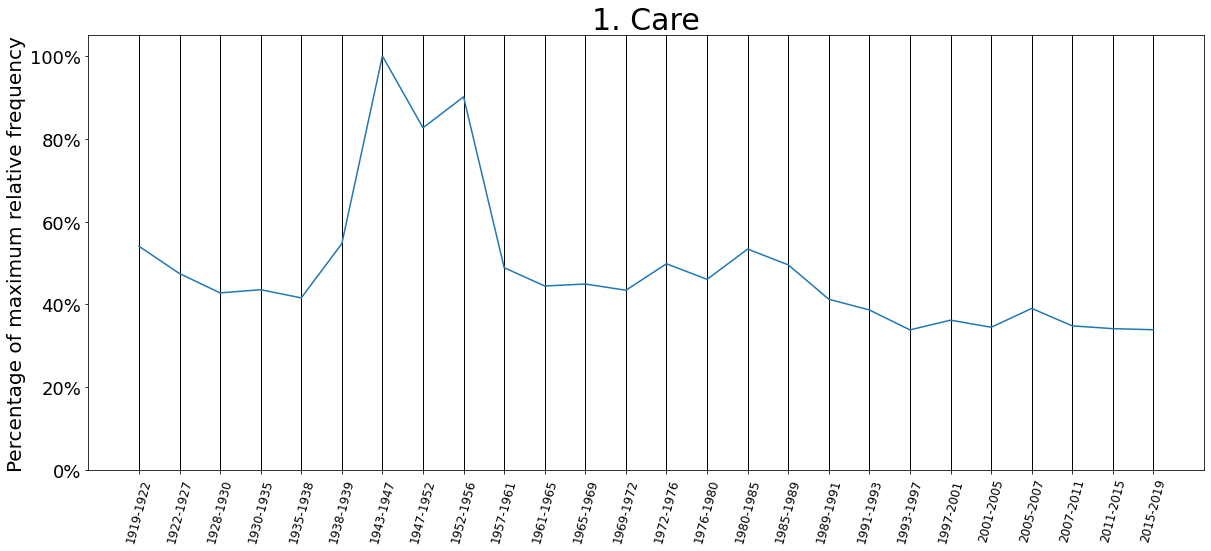

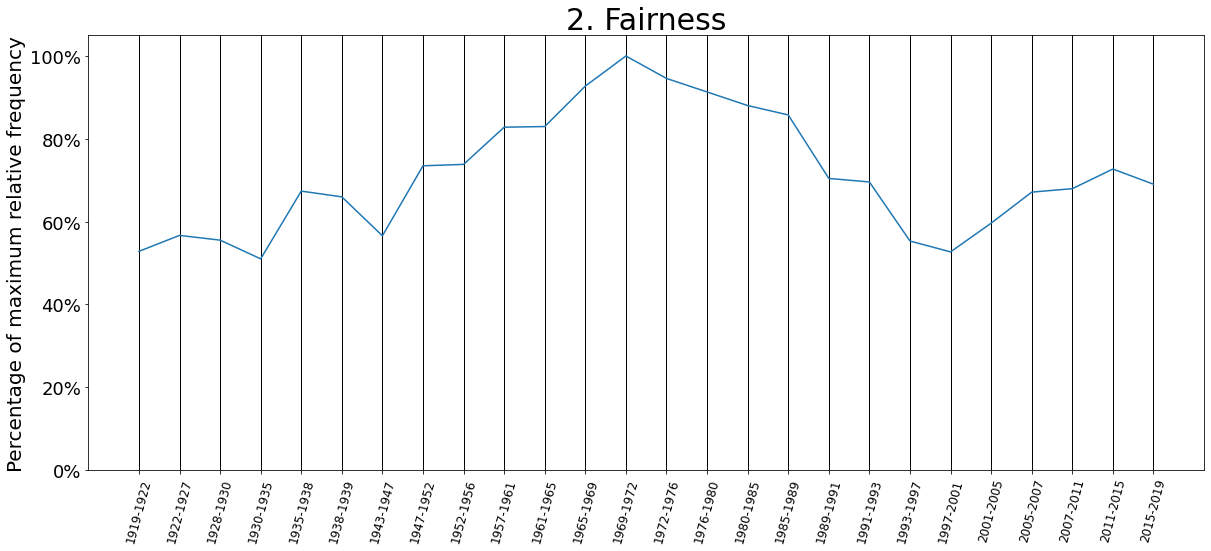

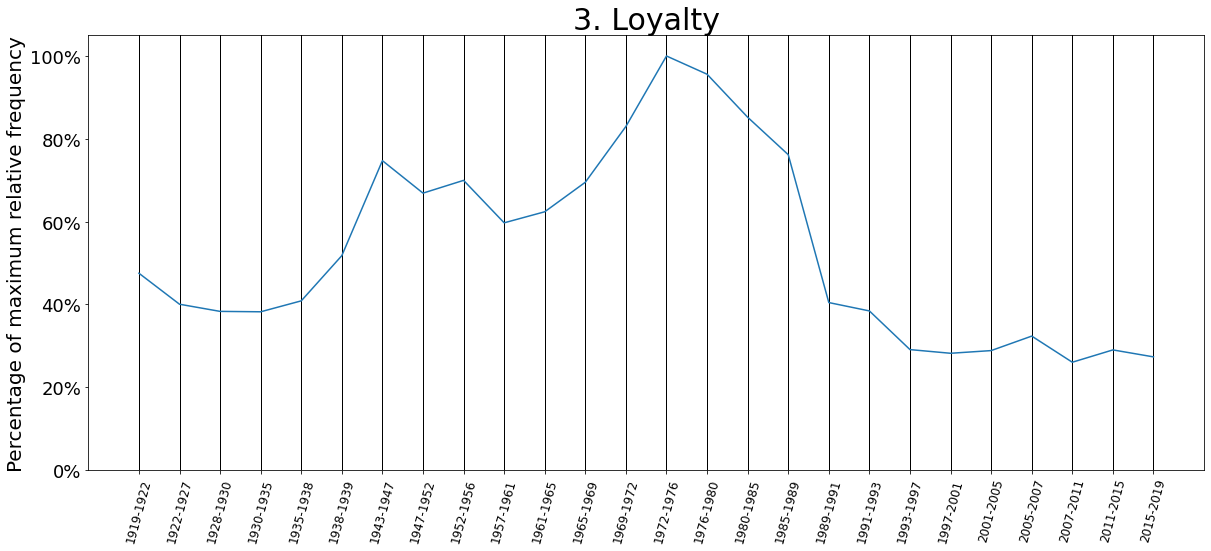

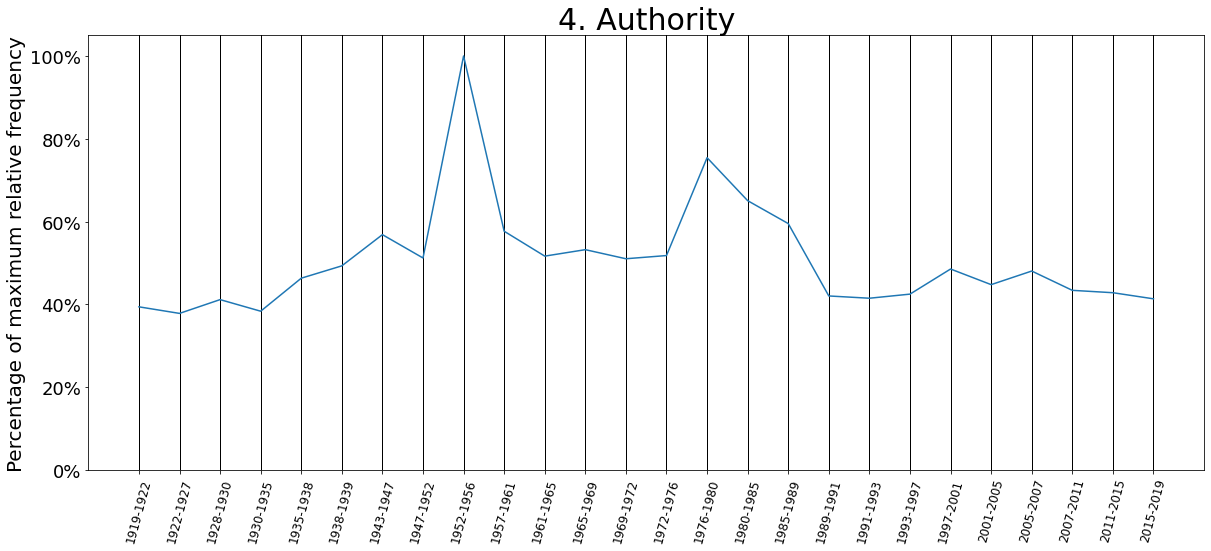

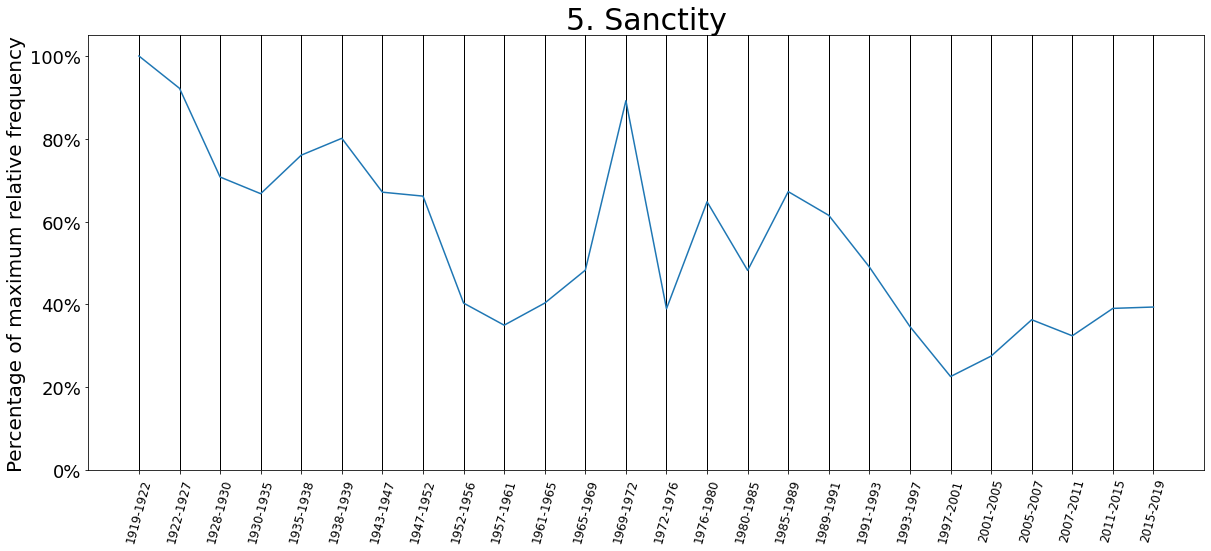

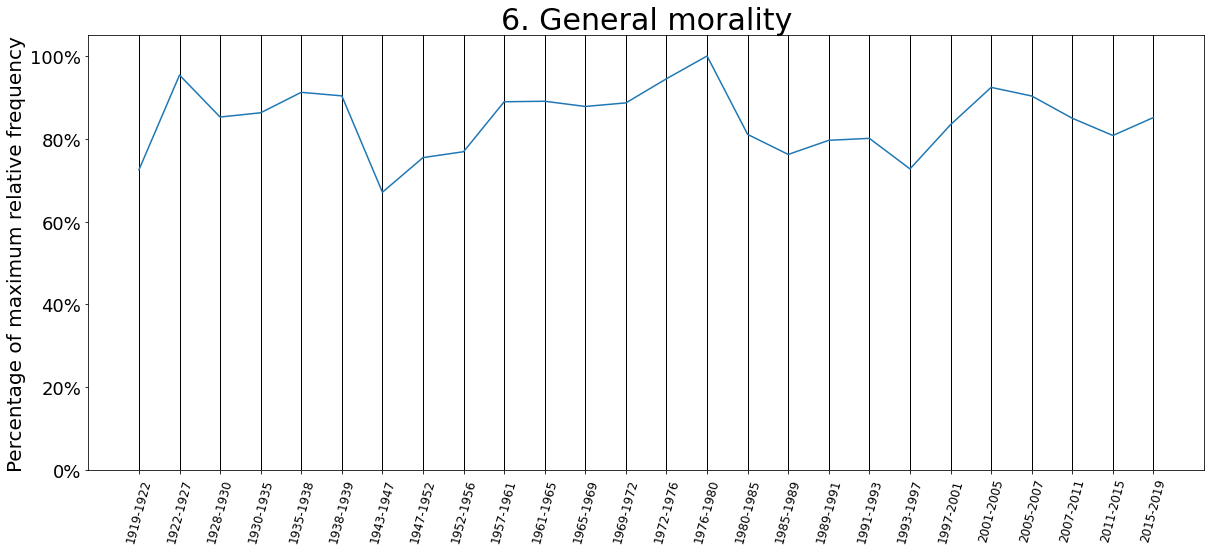

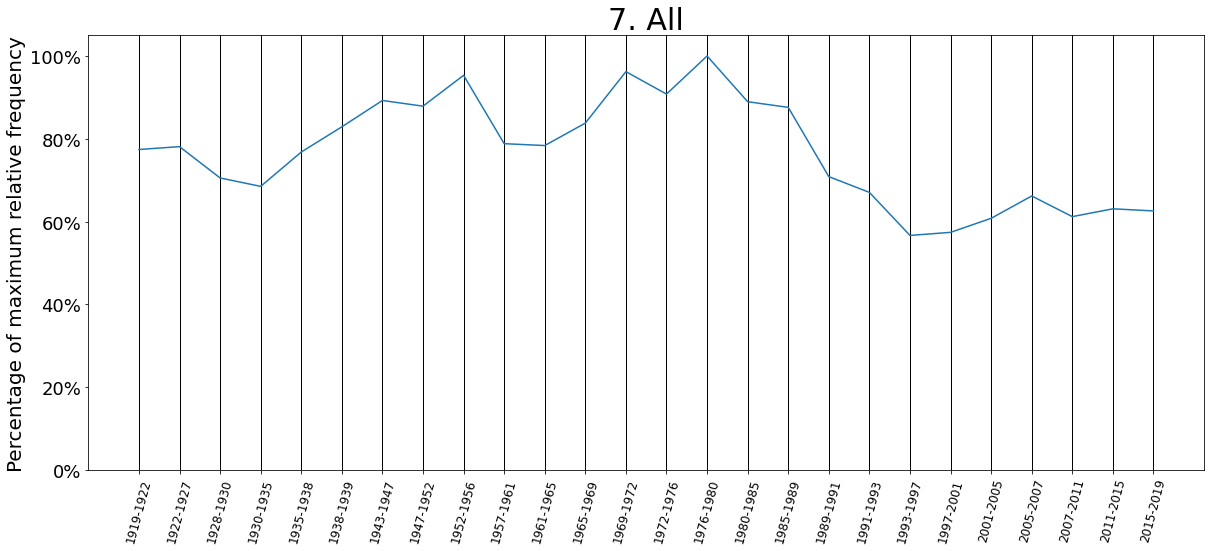

In [7]:
f2timeseries = {f: dict_dict_get(counts_scaled, f) for f in f2w_aggregated} 
f2timeseries['7. All'] = {p: np.sum(list(pc.values())) for p, pc in counts_scaled.items()}
counts_scaled_max = np.max(list(f2timeseries['7. All'].values()))
f2timeseries['7. All'] = {p: np.round(100 * pc / counts_scaled_max, 3) for p, pc in f2timeseries['7. All'].items()}

figs = []; axs = []
for _ in range(7):
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    figs.append(fig); axs.append(ax)

for (f, f_timeseries), fig, ax in zip(f2timeseries.items(), figs, axs):
    ax.set_title(f, size=30)
    ax.set_ylim(0, 105)
    ax.set_ylabel('Percentage of maximum relative frequency', size=20)
    ax.set_yticklabels(('0%', '20%', '40%', '60%', '80%', '100%'), size=18)


    # print(f, f_timeseries)
    ax.plot(f_timeseries.keys(), f_timeseries.values())
    ax.tick_params(axis='x', labelrotation=75, labelsize=12)
    ax.grid(axis='x', color='k', linestyle='-', linewidth=1)
    fig.savefig(f'fig_{f[0]}.png')
    fig.show()

# Analyse the data

### Basic correlations

In [7]:
from scipy.stats import pearsonr

def pearsonr_pval(x, y):
    return pearsonr(x,y)[1]
def pval2star(pval: float) -> str:
    if .01 < pval < .05:
        return ' *' 
    if pval < .01:
        return ' **'
    return ''

df = pd.DataFrame(f2timeseries)
periods = sorted(list(map(lambda x:x.replace('.json', '').split('-'), os.listdir(DATA_COUNTS_PATH))))[:-1]
periods = list(map(lambda x:int(np.mean([int(x[1]), int(x[0])])) - 1919, periods))
df['Period'] = periods
df_corr = df.corr(method='pearson').round(decimals=3).drop('Period', axis=0)
df_corr_pvals = df.corr(method=pearsonr_pval #type:ignore
                ).round(decimals=3
                ).drop('Period', axis=0
                ).applymap(pval2star)

df_corr_final = df_corr.astype(str) + df_corr_pvals
df_corr_final_period = df_corr_final.iloc[:, -1]
# print(df_corr_final[df_corr_final.columns[:-1]])
# print(df_corr_final[df_corr_final.columns[:-1]].shape)
# t = np.tril(df_corr_final[df_corr_final.columns[:-1]])
# print(t.shape)
df_corr_final = pd.DataFrame(np.tril(df_corr_final[df_corr_final.columns[:-1]]))
df_corr_final['Period'] = df_corr_final_period.values
# print(df_corr_final.columns, df_corr.columns)
df_corr_final.columns = df_corr.columns
df_corr_final.index = df_corr.index


mean_sd_col = [f'{np.mean(list(f_timeseries.values())).round(2)} ({np.std(list(f_timeseries.values())).round(2)})' for i, (f, f_timeseries) in enumerate(f2timeseries.items())]
df_corr_final['Mean (SD)'] = mean_sd_col
def prettify(x) -> str:
    if isinstance(x, int):
        return ''
    if x == '1.0':
        return '-'
    return x
df_corr_final = df_corr_final[['Mean (SD)', 'Period', *df.columns[:6]]].applymap(prettify)
df_corr_final.to_csv('df_corr_final.csv', index=True)
df_corr_final


,Mean (SD),Period,1. Care,2. Fairness,3. Loyalty,4. Authority,5. Sanctity,6. General morality
1. Care,48.62 (16.66),-0.479 *,-,,,,,
2. Fairness,71.39 (14.2),0.215,0.013,-,,,,
3. Loyalty,53.08 (22.49),-0.247,0.505 **,0.748 **,-,,,
4. Authority,50.82 (13.09),-0.031,0.571 **,0.457 *,0.624 **,-,,
5. Sanctity,55.16 (20.93),-0.737 **,0.258,-0.068,0.233,-0.153,-,
6. General morality,84.48 (7.77),0.011,-0.471 *,0.324,0.094,-0.039,-0.036,-
7. All,76.82 (12.57),-0.44 *,0.629 **,0.644 **,0.929 **,0.666 **,0.457 *,0.09


### Spearman-Brown split-half reliability

#### Get relative frequencies for all elements

In [8]:
from utils.reliability import split_half
from utils.list_utils import reduce_list

counts_elements_scaled = {
    p: {
        w: w_count / c['total_lemmas'] for w, w_count in c['counts'].items()
    }
    for p, c in counts.items()
}

all_elements = reduce_list([ws for f, ws in load_dict(f'{DATA_MFD_PATH}/f2w_pl.json').items()])

el2max = {}
for el in all_elements:
    el_max_period = list(counts_elements_scaled)[0]
    el_max_perc = 0
    for p, p_counts in counts_elements_scaled.items():
        if p_counts[el] > el_max_perc:
            el_max_period = p
            el_max_perc = p_counts[el]
    el2max[el] = (el_max_period, el_max_perc)

counts_elements_relative = {
    p : {
        w: 100 * np.round(w_count / el2max[w][1] if el2max[w][1] else 0, 3) for w, w_count in c.items()
    }
    for p, c in counts_elements_scaled.items()
}
el_df = pd.DataFrame(counts_elements_relative).T

#### Calculate Spearman-Brown split-half reliability for every set

In [9]:
def split_half_dict(x) -> dict:
    r, sem = split_half(x, 10000)
    return {'r': r, 'sem': sem}

f2_reliability = {f: split_half_dict(el_df[els].values.T) for f, els in f2w_aggregated.items()}

df_reliability = pd.DataFrame(f2_reliability).round(3).T
df_reliability.to_csv('df_reliability.csv', index=True)
df_reliability

,r,sem
1. Care,0.831,0.001
2. Fairness,0.235,0.005
3. Loyalty,0.765,0.001
4. Authority,0.752,0.001
5. Sanctity,0.913,0.000
6. General morality,0.795,0.001


## Linear regressions

In [41]:
import statsmodels.api as sm

x = df['Period'].values
x2 = sm.add_constant(x)
for f in df.columns[:-1]:
    y = df[f].values
    est = sm.OLS(y, x2)
    est2 = est.fit()
    print(f'\t\t{f}')
    print(est2.summary())
    print()

		1. Care
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     7.141
Date:                Mon, 30 May 2022   Prob (F-statistic):             0.0133
Time:                        16:13:08   Log-Likelihood:                -106.65
No. Observations:                  26   AIC:                             217.3
Df Residuals:                      24   BIC:                             219.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.6465      6.039     10.37